In [1]:
"""
Notebook Matrix Profile – ampiimts Python 3.11 package

Goal:
From pre processing signal with original value, normalize value, timestamp. 
We identify discord and motifs with a fix window on matrix profile methode (stumpy.maamp)
"""
import numpy as np
import pandas as pd
import ampiimts
import time
import os
import stumpy

In [2]:
#import files
folder = '../../dataset/pollution'
pds = []
with os.scandir(folder) as entries:
    for entry in entries:
        if entry.is_file() and entry.name.endswith('csv'):
            # list of sensors with some parameters -> list[pd.DataFrame[timestamp, value1, value2, etc..., latitude, longitude]]) 
            pds.append(pd.read_csv(folder+'/'+entry.name))
len(pds)
pds = pds[:3]
# and not entry.name.startswith('pollutionData')

In [ ]:
pds_normalized = ampiimts.pre_processed(pds)

mx_profile = ampiimts.matrix_profile(pds_normalized)



[WINDOW LIST] Fenêtre retenue (variables séparées) → 14 days 02:40:00


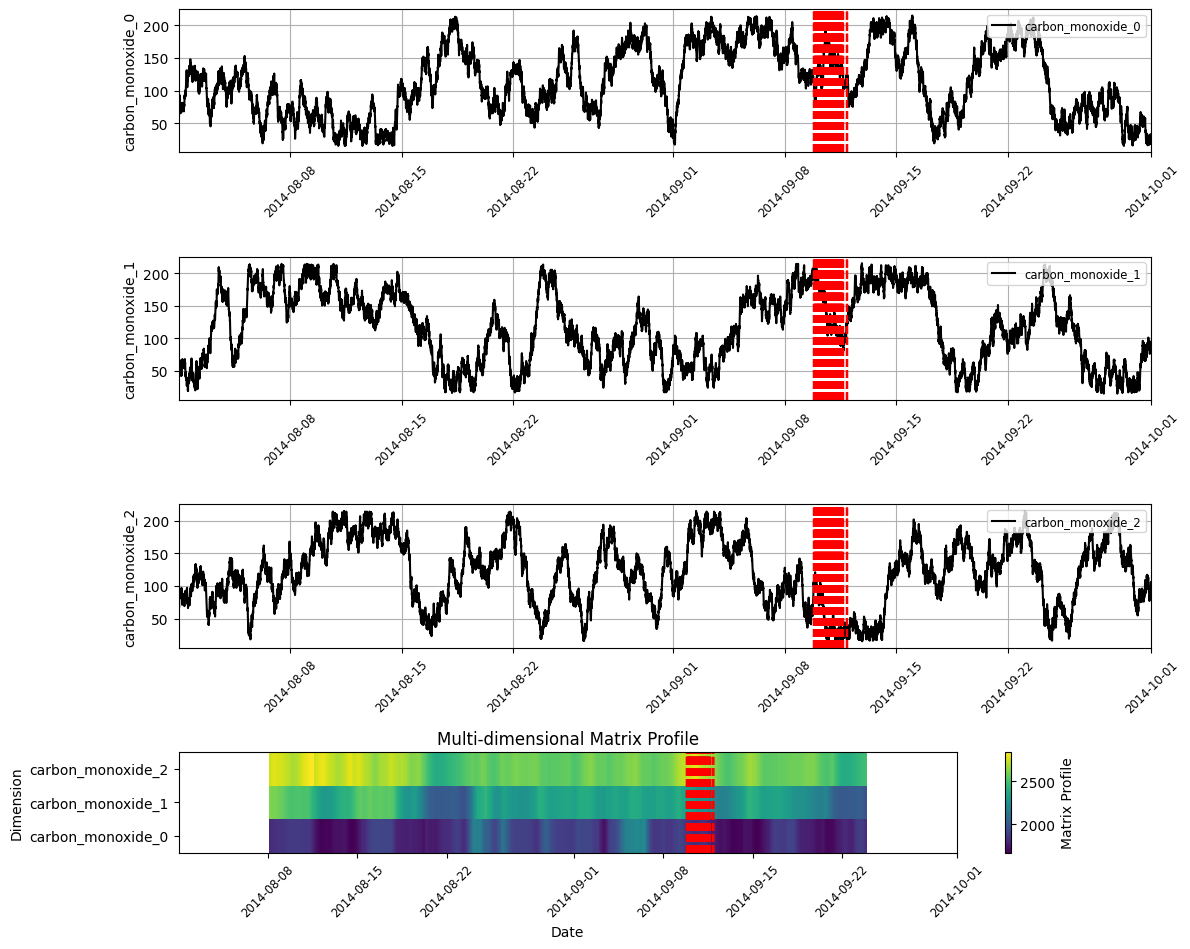

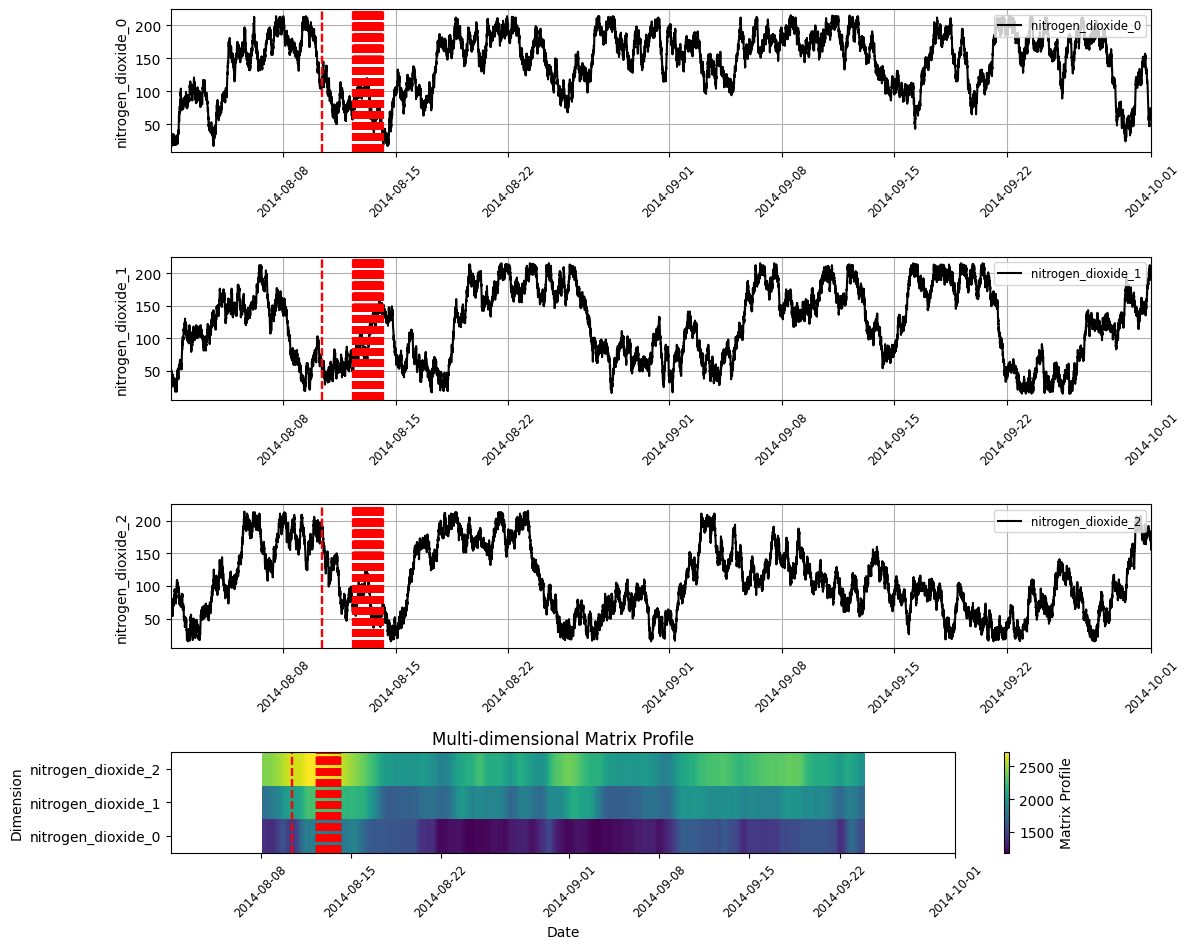

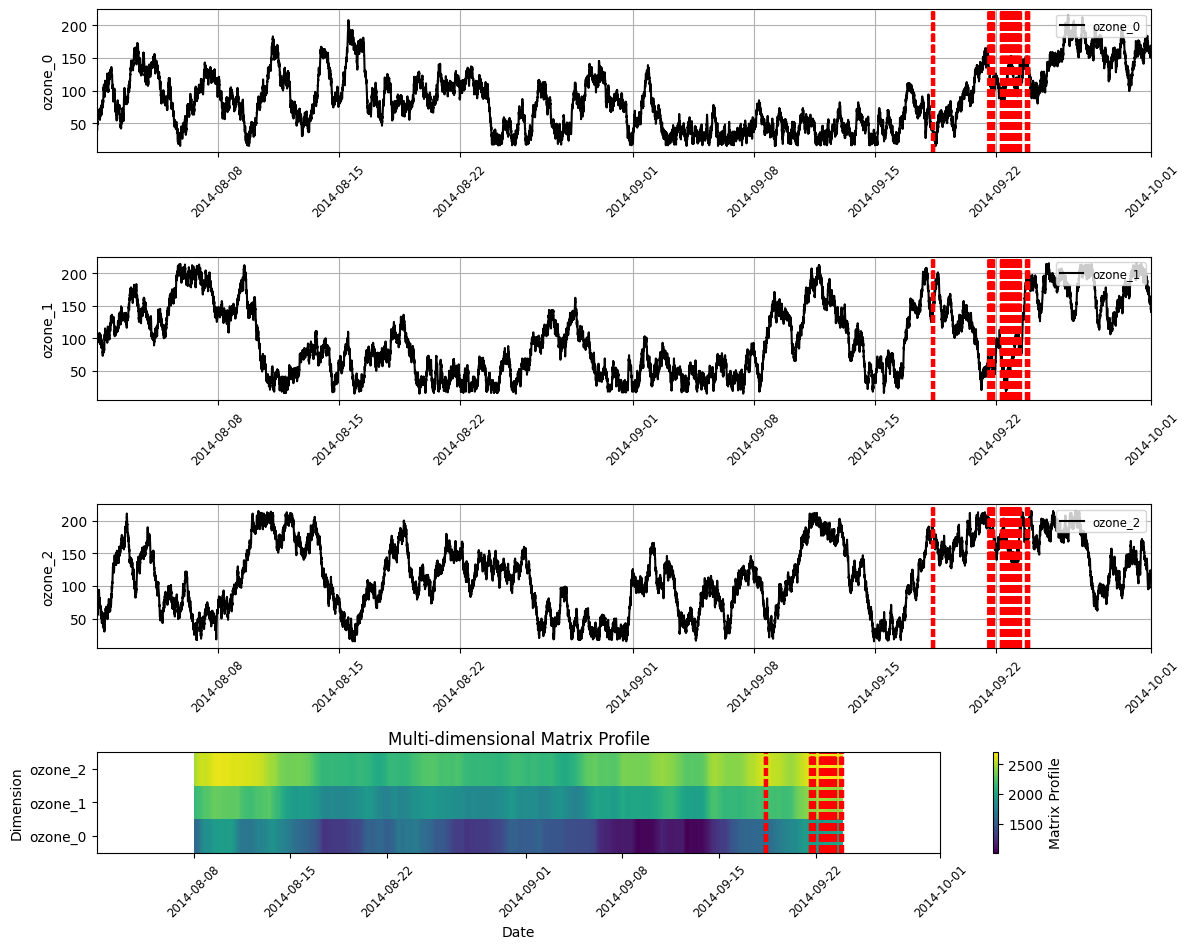

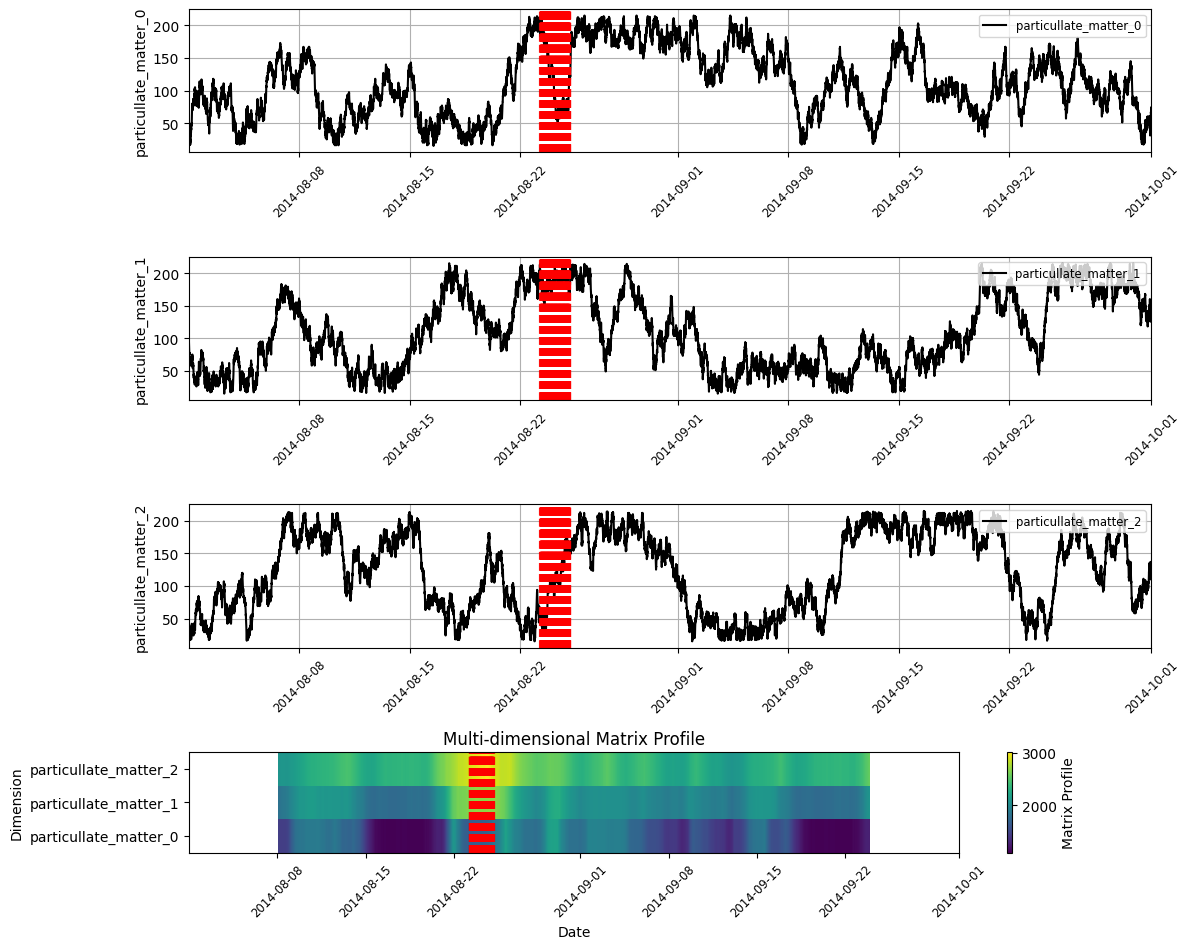

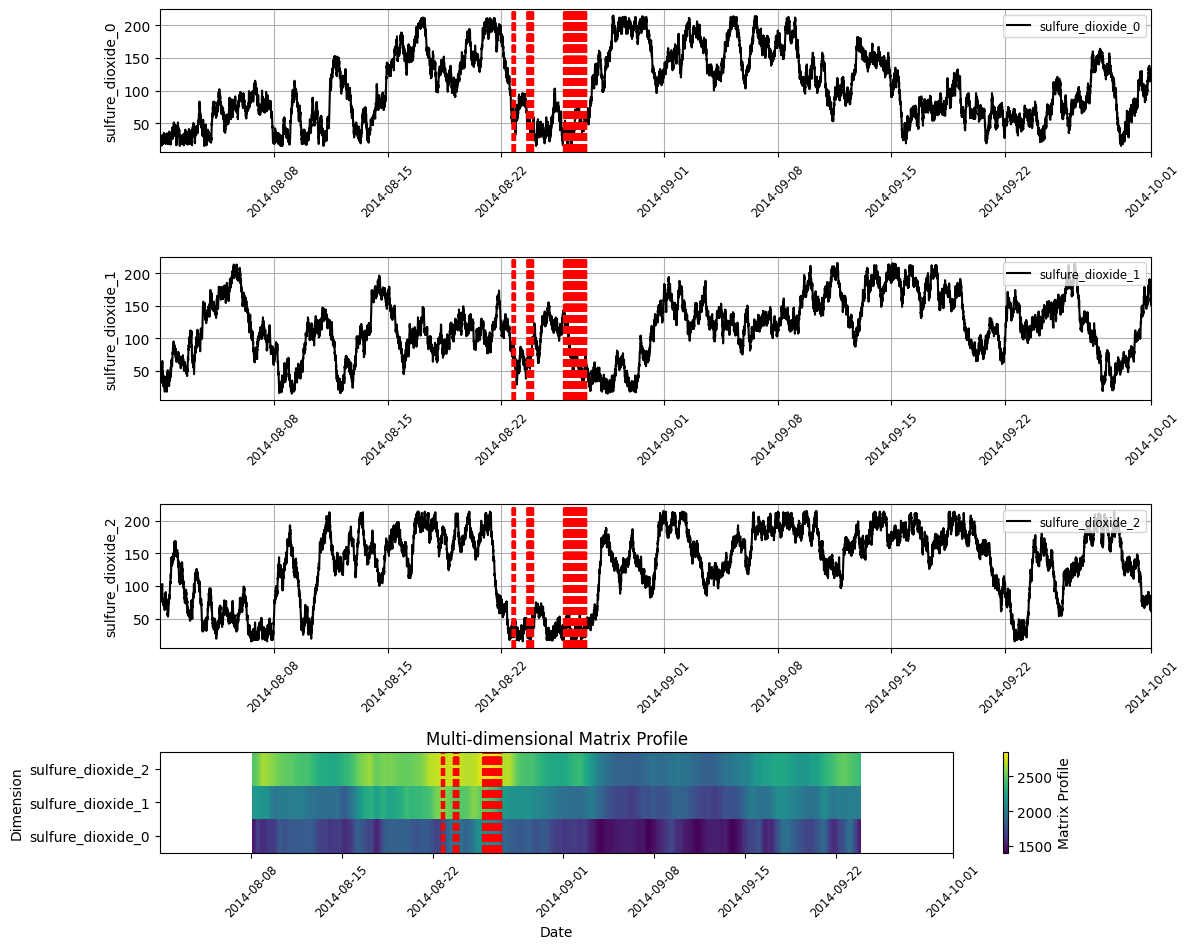

In [11]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

def plot_multidim_patterns_and_discords(df, result, figsize=(12, 6), tick_step=500):
    """
    Trace les séries multi-dimensionnelles avec motifs, discords,
    et une heatmap du matrix profile correctement décalée.
    
    Parameters
    ----------
    df : pandas.DataFrame
        Série temporelle multi-dimensionnelle (index DatetimeIndex).
    result : dict
        Issue de discover_patterns_mstump_mmotifs_aligned, contenant :
        - "matrix_profile"  : DataFrame (len=n−m+1 × n_dim), index DatetimeIndex
        - "window_size"     : int
        - "discord_indices" : list d’indices centraux
        - "patterns"        : list de dicts {"pattern_label", "motif_indices_debut", ...}
    figsize : tuple
    tick_step : int
    """
    # --- 0) Récupérations ---
    profile_df   = result["matrix_profile"]        # shape (n-m+1) × n_dim
    mp            = profile_df.values.T            # (n_dim, prof_len)
    center_dates  = profile_df.index.to_pydatetime()
    window_size   = result["window_size"]
    discords      = result.get("discord_indices", [])
    patterns      = result.get("patterns", [])
    
    n_dim, prof_len = mp.shape
    n              = len(df)
    
    # 1) Construction des edges X pour la heatmap
    dnums = mdates.date2num(center_dates)
    diffs = np.diff(dnums)
    xedges = np.empty(prof_len + 1)
    xedges[1:-1] = dnums[:-1] + diffs/2
    xedges[0]     = dnums[0]   - diffs[0]/2
    xedges[-1]    = dnums[-1]  + diffs[-1]/2
    yedges = np.arange(n_dim + 1)
    
    # 2) Création figure + axes (sharex pour aligner)
    fig, axs = plt.subplots(
        n_dim + 1, 1,
        figsize=(figsize[0], figsize[1] * (1 + 0.2 * n_dim)),
        sharex=True,
        gridspec_kw={"height_ratios": [1] * n_dim + [0.7]}
    )
    motif_colors = ["tab:green", "tab:purple", "tab:blue", "tab:orange"]
    
    # 3) Tracé des séries, motifs et discords
    for dim, col in enumerate(df.columns):
        ax = axs[dim]
        ax.plot(df.index, df[col], color="black", label=col)
        # motifs (alignés sur toutes les dims)
        for i, pat in enumerate(patterns):
            c = motif_colors[i % len(motif_colors)]
            for j, s in enumerate(pat["motif_indices_debut"]):
                e = s + window_size
                ax.axvspan(
                    df.index[s],
                    df.index[e],
                    color=c,
                    alpha=0.3,
                    label=(pat["pattern_label"] if j == 0 else None),
                )
        # discords
        for d in discords:
            ax.axvline(
                df.index[d],
                color="red",
                linestyle="--",
                alpha=0.5,
            )
        ax.set_ylabel(col)
        ax.legend(loc="upper right", fontsize="small")
        ax.grid(True)
        # afficher les dates sur chaque subplot
        ax.xaxis.set_major_locator(mdates.AutoDateLocator())
        ax.xaxis.set_major_formatter(mdates.DateFormatter("%Y-%m-%d"))
        ax.tick_params(axis="x", rotation=45, labelsize="small", labelbottom=True)
    
    # 4) Heatmap via pcolormesh sur la plage valide
    axh = axs[-1]
    cmap = plt.cm.viridis.copy()
    cmap.set_bad("white")
    
    mesh = axh.pcolormesh(
        xedges, yedges, mp,
        cmap=cmap,
        shading="flat"
    )
    fig.colorbar(mesh, ax=axh, label="Matrix Profile")
    
    # redessiner discords
    for d in discords:
        xd = mdates.date2num(df.index[d])
        axh.axvline(xd, color="red", linestyle="--", alpha=0.5)
    # redessiner motifs
    for i, pat in enumerate(patterns):
        c = motif_colors[i % len(motif_colors)]
        for s in pat["motif_indices_debut"]:
            x0 = mdates.date2num(df.index[s])
            x1 = mdates.date2num(df.index[s + window_size])
            rect = plt.Rectangle(
                (x0, 0),
                x1 - x0,
                n_dim,
                edgecolor=c,
                facecolor="none",
                linewidth=1.5,
                alpha=0.7
            )
            axh.add_patch(rect)
    
    # 5) Formatage final de l'axe X & Y de la heatmap
    axh.set_xlim(df.index[0], df.index[-1])
    axh.xaxis.set_major_locator(mdates.AutoDateLocator())
    axh.xaxis.set_major_formatter(mdates.DateFormatter("%Y-%m-%d"))
    axh.tick_params(axis="x", rotation=45, labelsize="small")
    axh.set_yticks(np.arange(n_dim) + 0.5)
    axh.set_yticklabels(df.columns)
    axh.set_xlabel("Date")
    axh.set_ylabel("Dimension")
    axh.set_title("Multi-dimensional Matrix Profile")
    
    plt.tight_layout()
    plt.show()


for pd, mx in zip(ampiimts.synchronize_on_common_grid(pds), mx_profile):
    plot_multidim_patterns_and_discords(pd, mx)

